# DNN implemented with TensorFlow

In the previous notebooks we have used networks which has been implemented from scratch and relies on `numpy`.

In this notebook we will try out a network which utilizes `TensorFlow` rather than `numpy` for performing:

* forward propagation
* cost calculation
* backward propagation

In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from tf_model import normalize_img, one_hot_matrix, SimpleTFModel

# Suppress TensorFlow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load data

In this notebook we will use the MNIST dataset from `TensorFlow Datasets`. It contains images with written numbers from 0-9.

In [2]:
# Load mnist dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2023-01-07 11:43:01.479408: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-07 11:43:01.479426: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 11:43:01.479440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hojve-pc): /proc/driver/nvidia/version does not exist
2023-01-07 11:43:01.479650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Inspect dataset

Start by inspecting the data. A TensorFlow `Dataset` has a lot of properties, for reference see [TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Datasethttps://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [3]:
# Print info
print(ds_info.splits['train'].num_examples)
print(ds_train.element_spec)

# Calculate number of classes in label
num_classes = ds_info.features['label'].num_classes
print(num_classes)

60000
(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
10


In [4]:
# Print one training example
for x_train, _ in ds_train:
    print(x_train)
    break

tf.Tensor(
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  

2023-01-07 11:43:01.647820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


We can visualize some of the images.

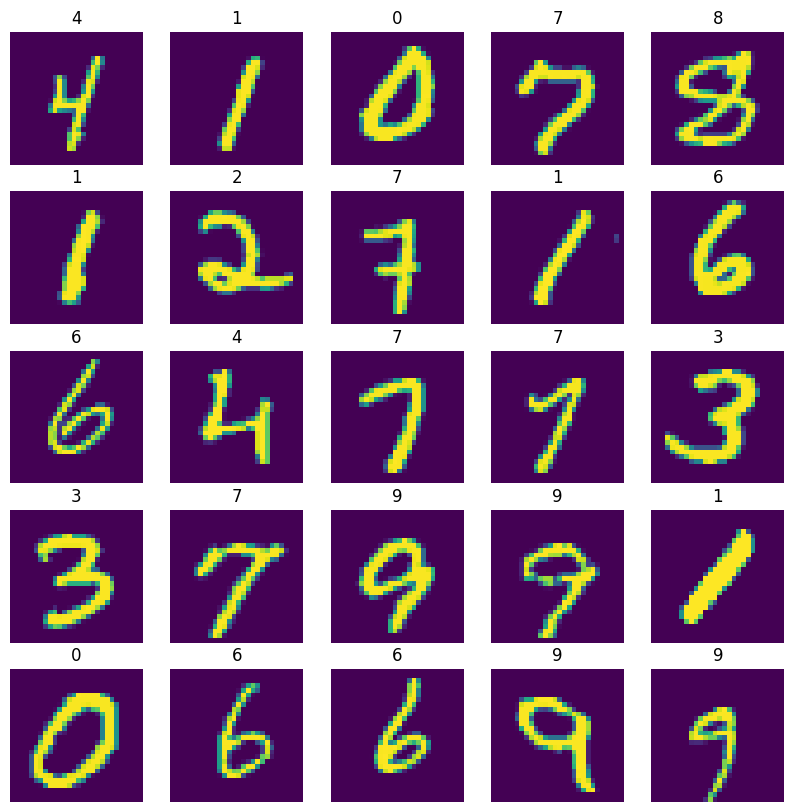

In [5]:
images_iter = iter(x_train for x_train, _ in ds_train)
labels_iter = iter(y_train for _, y_train in ds_train)

plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

## Preprocess data

Next we preprocess the images before training.

### Images

The images will be processed in the following way:

* casted to `tf.float32` and normalized by 255.0
* flattened to reduce dimension to `(num_pixels,)`

```python
def normalize_img(image, label):
    """Transform image and normalize."""
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1, ])
    return image, label
```

### Labels

Labels are getting One-Hot encoded into dimension `(num_classes,)`

```python
def one_hot_matrix(image, label, depth=2):
    """One-hot encoding for single label."""
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), (depth,))
    return image, one_hot
```

In [6]:
# Prep data

# Normalize training data
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# One-hot encode training labels
ds_train = ds_train.map(lambda img, lbl: one_hot_matrix(img, lbl, depth=num_classes),
                        num_parallel_calls=tf.data.AUTOTUNE)

# Normalize test data
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# One-hot encode test labels
ds_test = ds_test.map(lambda img, lbl: one_hot_matrix(img, lbl, depth=num_classes),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
# Print element spec after preprocessing
print(ds_train.element_spec)
print(ds_test.element_spec)

(TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))
(TensorSpec(shape=(784,), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.float32, name=None))


The `Dataset` API has some nice functionalities for speeding up the traning time.

By caching the datasets we we will save some operations (like file opening and data reading) from being executed during each epoch [reference](https://www.tensorflow.org/guide/data_performance#caching).

In [8]:
# Cache train and test data
ds_train = ds_train.cache()
ds_test = ds_test.cache()

In [9]:
# Shuffle data for true randomness and to reduce memory usage
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_test.shuffle(ds_info.splits['test'].num_examples)

## Train model

Next we instantiate the model and let it train for a number of epochs.

In [10]:
# Instantiate model
model = SimpleTFModel()

In [11]:
# Train model
model.call(X_train=ds_train, X_test=ds_test, num_classes=num_classes,
           learning_rate=0.001, num_epochs=50, minibatch_size=128, print_cost=True)

Cost after epoch 0: 0.6528307795524597
Train accuracy: 0.06972281634807587
Test accuracy: 0.08607594668865204
Cost after epoch 10: 0.14026083052158356
Train accuracy: 0.082942433655262
Test accuracy: 0.07974683493375778
Cost after epoch 20: 0.10765436291694641
Train accuracy: 0.08251599222421646
Test accuracy: 0.08227848261594772
Cost after epoch 30: 0.089997299015522
Train accuracy: 0.08592750877141953
Test accuracy: 0.08291139453649521
Cost after epoch 40: 0.07653827220201492
Train accuracy: 0.08507462590932846
Test accuracy: 0.08632911741733551
Cost after epoch 49: 0.06694977730512619
Train accuracy: 0.08997868001461029
Test accuracy: 0.09029535949230194


## Evaluate model

Let's evaluate the models performance.

Text(0.5, 1.0, 'Learning curve')

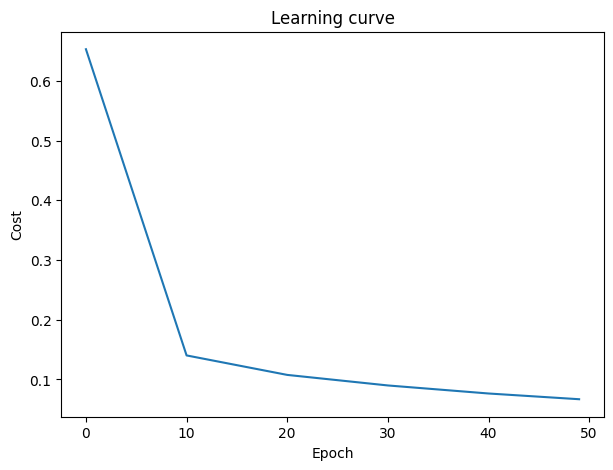

In [12]:
# Plot learning curve
plt.figure(figsize=(7,5))
plt.plot(model.learning_curve[:, 0], model.learning_curve[:, 1])
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Learning curve')

Text(0.5, 1.0, 'Accuracy')

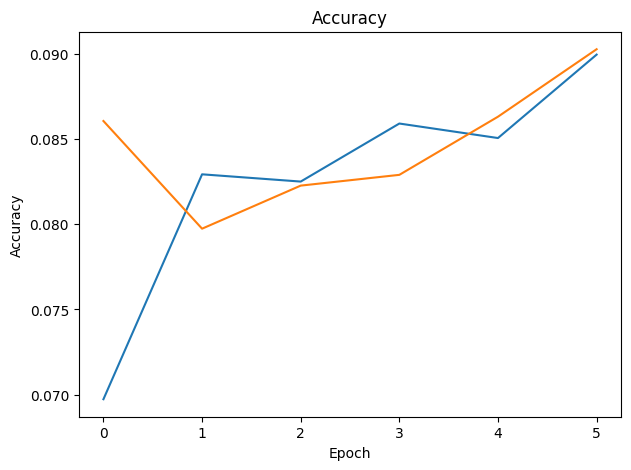

In [20]:
# Plot accuracy
plt.figure(figsize=(7,5))
plt.plot(np.squeeze(model.train_acc))
plt.plot(np.squeeze(model.test_acc))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')

The model is not performing great, but the purpose is to illustrate how seamless the backward propagation is with TensorFlow. By using the `GradienTape` functionality from TensorFlow we don't need to define the backward propagation and the networks derivatives with respect to our cost function.